In this notebook we will explore *model checking* using Lyrics framework.


In [1]:
import tensorflow as tf
import numpy as np

from lyrics.lyrics import (
    Domain,
    Predicate,
    Constraint,
    PointwiseConstraint,
)
from lyrics.world import current_world as world
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)
tf.random.set_seed(1)

In [3]:
n=20

Create the domain space *data = [-3,3]x[-3,3]*

In [4]:
r1 = np.linspace(-3, 3, num=n, endpoint=True, retstep=False, dtype=np.float32)
data=np.array([[a, b] for a in r1 for b in r1])

Create two figures *A* and *B* with *B* contained in *A*, such that
A=[-2,2]x[-2,2], B=[-1,1]x[-1,1]

Definition of positive and negative values of class *A*

In [5]:
dataApos=np.array([[a, b] for a,b in data if a <= 2 and a>=-2 and b <= 2 and b>=-2])
dataAneg = np.array([[a,b] for a,b in data if not (a <= 2 and a>=-2 and b <= 2 and b>=-2)])
dataA = np.concatenate((dataApos, dataAneg), axis=0)
dataA = tf.convert_to_tensor(dataA)
labelsApos = np.ones_like(dataApos[:,0:1])
labelsAneg = np.zeros_like(dataAneg[:,0:1])
labelsA = np.concatenate((labelsApos, labelsAneg), axis=0)
labelsA = tf.convert_to_tensor(labelsA)

Definition of positive and negative values of class *B*

In [6]:
dataBpos= np.array([[a, b] for a,b in data if a <= 1 and a>=-1 and b <= 1 and b>=-1])
dataBneg = np.array([[a,b] for a,b in data if not (a <= 1 and a>=-1 and b <= 1 and b>=-1)])
dataB = np.concatenate((dataBpos, dataBneg), axis=0)
dataB = tf.convert_to_tensor(dataB)
labelsBpos = np.ones_like(dataBpos[:,0:1])
labelsBneg = np.zeros_like(dataBneg[:,0:1])
labelsB = np.concatenate((labelsBpos, labelsBneg), axis=0)
labelsB = tf.convert_to_tensor(labelsB)

Plot the two figures *A* and *B*.

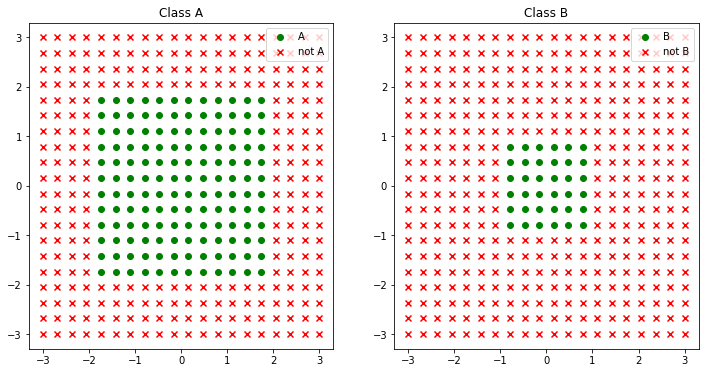

In [7]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1).title.set_text('Class A')
plt.scatter(dataApos[:,0],dataApos[:,1], color="green", marker="o", label="A")
plt.scatter(dataAneg[:,0],dataAneg[:,1], color="red", marker="x", label="not A")
plt.legend()
plt.subplot(1,2,2).title.set_text('Class B')
plt.scatter(dataBpos[:,0],dataBpos[:,1], color="green", marker="o", label="B")
plt.scatter(dataBneg[:,0],dataBneg[:,1], color="red", marker="x", label="not B")
plt.legend()

plt.show()

Define a neural network to tell if a point is in a certain depending on its coordinates.

In [8]:
class FCL(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FCL, self).__init__(**kwargs)
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(1)
        ])

    def call(self, inputs):
        return self.model(inputs)

    def cost(self, y, x):
        y_hat = self.call(x)
        losses = tf.keras.losses.binary_crossentropy(y, y_hat, from_logits=True)
        return tf.reduce_mean(losses)

Instantiate two neural networks. One for each class *A* or *B*

In [9]:
is_A, is_B = FCL(),FCL()


Add two pointwise constraints on the different neural networks in order to enforce the available class supervisions

In [10]:
# world.lambda_p = 1.5
lambda_p = 1.5
ptc_1 = PointwiseConstraint(is_A, labelsA,  dataA, weight = lambda_p)
ptc_2 = PointwiseConstraint(is_B, labelsB,  dataB, weight = lambda_p)

A training step for the supervised data

In [11]:
optimizer = tf.keras.optimizers.Adam(0.1)
@tf.function
def train_step_supervised(model):
    with tf.GradientTape() as tape:
        loss = model.loss()
        grads = tape.gradient(loss, {'A':is_A.trainable_variables, 'B':is_B.trainable_variables})
    optimizer.apply_gradients(zip(grads['A'], is_A.trainable_variables))
    optimizer.apply_gradients(zip(grads['B'], is_B.trainable_variables))
    return loss

A general training loop

In [12]:
def train(model, nb_epochs, train_step_function):
    epochs = range(1,nb_epochs + 1)
    print('Loss at epoch 0 = {}'.format(model.loss()))
    for epoch in epochs:
        loss = train_step_function(model)
        if epoch % 250 == 0:
            print('Loss at epoch {} = {}'.format(epoch, loss))

Train the two neural networks on the supervised data

In [13]:
train(world, 1000, train_step_supervised)

Loss at epoch 0 = 2.531559944152832
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Loss at epoch 250 = 0.011934810318052769
Loss at epoch 500 = 0.003202966880053282
Loss at epoch 750 = 0.0015957599971443415
Loss at epoch 1000 = 0.0009800402913242579


Define a domain **points** that includes both *A* and *B* datapoints.

In [14]:
points = Domain(domain_name="points", elements=data)

Define two predicates for the classes (*A*, *B*), where A(p) and B(p) are the degree of confidence (fuzzy value) that the point p
belongs to class *A* and *B*, respectively.

In [15]:
Predicate(predicate_name="A", domains=("points",), concrete_function=is_A)
Predicate(predicate_name="B", domains=("points",), concrete_function=is_B)

Enumeration of all the possible boolean functions assuming *A* and *B* always true or false, by turn.

In [16]:
n=4
base =[[0,0], [1,0], [0,1], [1,1]]
formulas = []
for i in range(2**n):
    s = ("{0:0%db}" % n).format(i)
    s = [int(c) for c in s]
    atoms =[]
    for k in range(4):
        if s[k] == 1:
            if base[k][0] == 1:
                a = "A(x)"
            else:
                a = "not A(x)"
            if base[k][1] == 1:
                b = "B(x)"
            else:
                b = "not B(x)"
            subformula = "(%s and %s)" %(a,b)
            atoms.append(subformula)
    if len(atoms)>0:
        formula = " or ".join(atoms)
        formula = "forall x: " + formula
        formulas.append(formula)


Check if the model satisfy the truth-value of the listed formulas.


In [17]:
print("Some formulas with their corresponding truth-values\n")
for formula in formulas:
    print(formula)
    x=Constraint(formula)
    # print("truth-degree: ",sess.run(lyr.Constraint(formula).tensor))
    print("truth-degree: ",x.model.output)

Some formulas with their corresponding truth-values

forall x: (A(x) and B(x))
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to